# Portfolio Exam Part II

# Customer and Task

Our customer is the Halle Tourist-Information.

To be able to provide clothing recommendations for visiting tourists, we are tasked with analyzing local weather data in order to find characteristical weather conditions.

To achieve this we are going to use the data of the weather station Saaleaue. To keep computational costs in check we are going to establish a strategy based on the data of the year 2020 only.

Links:
- Tourist Office:     https://www.halle-tourismus.de/
- Weather Station:    https://www.bgc-jena.mpg.de/wetter/
- Documentation:      https://www.bgc-jena.mpg.de/wetter/Weatherstation.pdf

# Preparation

To get started we are going to import required modules and libaries which allow us to work our magic.

In [1]:
# importing libraries, modules and packages
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster
from sklearn.cluster import KMeans
import plotly_express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from yellowbrick.cluster import silhouette_visualizer

## Ingesting Data

In [2]:
# Load weather station data for the entire year 2020 of the weather station Saaleaue
df1 = pd.read_csv('https://www.bgc-jena.mpg.de/wetter/mpi_saale_2020a.zip') # 01.01.2020 to 30.06.2020
df2 = pd.read_csv('https://www.bgc-jena.mpg.de/wetter/mpi_saale_2020b.zip') # 01.07.2020 to 31.12.2020

In [3]:
# concatenating to get a single data frame with all data of 2020
df = pd.concat([df1, df2])

## First Data Inspection

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52534 entries, 0 to 26332
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        52534 non-null  object 
 1   p (mbar)         52534 non-null  float64
 2   T (degC)         52534 non-null  float64
 3   rh (%)           52534 non-null  float64
 4   sh (g/kg)        52534 non-null  float64
 5   Tpot (K)         52534 non-null  float64
 6   Tdew (degC)      52534 non-null  float64
 7   VPmax (mbar)     52534 non-null  float64
 8   VPact (mbar)     52534 non-null  float64
 9   VPdef (mbar)     52534 non-null  float64
 10  H2OC (mmol/mol)  52534 non-null  float64
 11  rho (g/m**3)     52534 non-null  float64
 12  wv (m/s)         52534 non-null  float64
 13  wd (deg)         52534 non-null  float64
 14  rain (mm)        52534 non-null  float64
 15  SWDR (W/m**2)    52534 non-null  float64
 16  SDUR (s)         52534 non-null  float64
 17  TRAD (degC) 

In [5]:
df.head(3)

,Date Time,p (mbar),T (degC),rh (%),sh (g/kg),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),...,ST008 (degC),ST016 (degC),ST032 (degC),ST064 (degC),ST128 (degC),SM008 (%),SM016 (%),SM032 (%),SM064 (%),SM128 (%)
0,01.01.2020 00:10:04,1019.28,-0.02,96.7,3.61,271.66,-0.48,6.10,5.90,0.20,...,2.08,2.88,3.9,6.14,8.81,32.5,30.09,31.64,21.55,29.76
1,01.01.2020 00:20:04,1019.19,0.04,96.6,3.62,271.72,-0.43,6.13,5.92,0.21,...,2.07,2.88,3.9,6.14,8.80,32.5,30.09,31.64,21.55,29.76
2,01.01.2020 00:30:04,1019.11,0.10,97.2,3.66,271.78,-0.29,6.15,5.98,0.17,...,2.06,2.87,3.9,6.14,8.81,32.5,30.09,31.64,21.55,29.76


In [6]:
df.tail(3)

,Date Time,p (mbar),T (degC),rh (%),sh (g/kg),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),...,ST008 (degC),ST016 (degC),ST032 (degC),ST064 (degC),ST128 (degC),SM008 (%),SM016 (%),SM032 (%),SM064 (%),SM128 (%)
26330,31.12.2020 23:40:00,988.07,2.03,88.8,3.96,276.13,0.39,7.07,6.28,0.79,...,2.66,3.24,4.16,6.09,8.67,37.32,33.10,33.01,30.75,31.8
26331,31.12.2020 23:50:00,988.08,1.93,88.5,3.92,276.03,0.24,7.02,6.22,0.81,...,2.67,3.25,4.16,6.09,8.67,37.32,33.09,33.01,30.76,31.8
26332,01.01.2021 00:00:00,988.07,1.87,89.9,3.97,275.97,0.40,6.99,6.29,0.71,...,2.67,3.25,4.16,6.09,8.67,37.32,33.09,33.01,30.76,31.8


Observations: 
- the original dataframe contains 30 columns
- column names are very scientific not all variables are relateable
- the column 'Date Time' is not formated in ISO standard
- there is an entry of 2021 in the last line
- data comes in ten minute intervals

Procedure:
- format column 'Date Time' in ISO standard 
- set the column 'Date Time' as index
- remove last line with with 2021 data

In [7]:
# Convert "date time"-column to datetime datatype and set as index
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], format="%d.%m.%Y %H:%M:%S")
df = df.set_index('Date Time')

In [8]:
# dropping the last row to remove 2021 data
df.drop(df.tail(1).index,inplace=True) 

In order to undestand how to proceed we are going to inspect the mean, standard deviation, min / max values and the percentiles.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),52533.0,999.844270,9.372890,965.17,994.42,1000.70,1005.96,1030.63
T (degC),52533.0,10.771671,7.676381,-8.13,4.89,10.08,16.00,36.55
rh (%),52533.0,76.577823,20.822427,16.85,62.33,80.60,96.00,100.00
sh (g/kg),52533.0,6.357813,2.712042,1.34,4.17,5.86,8.02,16.45
Tpot (K),52533.0,283.945846,7.838281,263.42,278.04,283.36,289.27,309.58
Tdew (degC),52533.0,6.081506,6.086479,-13.39,1.25,6.03,10.62,21.74
VPmax (mbar),52533.0,14.541366,8.008416,3.30,8.66,12.36,18.21,61.29
VPact (mbar),52533.0,10.164988,4.299590,2.17,6.69,9.38,12.81,26.06
VPdef (mbar),52533.0,4.376284,5.902847,0.00,0.38,2.17,5.61,45.58
H2OC (mmol/mol),52533.0,10.175137,4.321003,2.15,6.68,9.39,12.82,26.19


Oberservations:
- the data in it's raw form has high standard deviations across most variables
- we find minimum of values of -9999.00 in some variables
- we find the dataframe has 52533 rows

Procedure:
- discard -9999.0 values
- standardize the data
- resample data to daily time frame to be more interpretable and faster to compute
- rename columns to more understandable names
- select suitable columns for further analysis

## Data Preparation

Before beginning with the analysis we are going to implement the data preparation mentioned previously under procedures.

In [10]:
# wind velocity contains invalid data, e.g. -9999 is not a valid velocity, similarly for TRAD (degC)
# this dataset seems to use -9999.0 as NaN
df = df.replace(-9999.0, np.nan)

Because many variables are really only understood by meterolgists, we will continue to work with those that are closer to a human intuition of weather, like temperature, windspeed, rainfall.
Besides that, the data also contains information about soil temperatures and humidity which we won't be working with, as these lag behind the actual weather trend.

In [11]:
# listing column names for renaming
df.columns

Index(['p (mbar)', 'T (degC)', 'rh (%)', 'sh (g/kg)', 'Tpot (K)',
       'Tdew (degC)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'wd (deg)', 'rain (mm)',
       'SWDR (W/m**2)', 'SDUR (s)', 'TRAD (degC)', 'Rn (W/m**2)',
       'ST002 (degC)', 'ST004 (degC)', 'ST008 (degC)', 'ST016 (degC)',
       'ST032 (degC)', 'ST064 (degC)', 'ST128 (degC)', 'SM008 (%)',
       'SM016 (%)', 'SM032 (%)', 'SM064 (%)', 'SM128 (%)'],
      dtype='object')

In [12]:
# renaming columns we are keeping to be more comprehensible
df = df.rename(columns={
    'p (mbar)': 'air pressure (mbar)',
    'T (degC)': 'air temperature (°C)',
    'rh (%)': 'relative humidity (%)',
    'wv (m/s)': 'wind velocity (m/s)',
    'wd (deg)': 'wind direction (°)',
    'SWDR (W/m**2)': 'solar radiation (W/m²)'
})

In [13]:
# Removing all features a regular person can't interpret
df = df.drop(['sh (g/kg)', 'Tpot (K)', 'Tdew (degC)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 
       'H2OC (mmol/mol)', 'rho (g/m**3)',
       'SDUR (s)', 'TRAD (degC)', 'Rn (W/m**2)', 'ST002 (degC)', 'ST004 (degC)', 'ST008 (degC)', 'ST016 (degC)',
       'ST032 (degC)', 'ST064 (degC)', 'ST128 (degC)', 'SM008 (%)',
       'SM016 (%)', 'SM032 (%)', 'SM064 (%)', 'SM128 (%)'], axis=1)

Procedure:
- store copies of daily min and max values resampled to daily timeframe
- replace original values within 24 hours with the mean of those values over 24 hours

In [14]:
# storing copies of daily min and max values
df_min = df.resample('24H').min()
df_max = df.resample('24H').max()

In [15]:
# Resample data to single data point every 24 hours
df = df.resample('24H').mean()

In [16]:
# checking for missing values
df.isna().sum()

air pressure (mbar)       0
air temperature (°C)      0
relative humidity (%)     0
wind velocity (m/s)       0
wind direction (°)        0
rain (mm)                 0
solar radiation (W/m²)    0
dtype: int64

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
air pressure (mbar),366.0,999.852423,9.093015,966.192083,994.635990,1000.404618,1005.550503,1028.954444
air temperature (°C),366.0,10.795216,6.430339,-2.388194,5.549115,10.651319,15.782865,25.174028
relative humidity (%),366.0,76.568954,11.391765,43.353056,68.201649,76.384167,86.171701,99.994444
wind velocity (m/s),366.0,1.816605,0.907785,0.739861,1.177153,1.565060,2.195503,6.726181
wind direction (°),366.0,163.728465,48.218081,46.838542,128.856615,170.348194,200.385069,258.608750
rain (mm),366.0,0.011132,0.032529,0.000000,0.000000,0.000035,0.006033,0.264653
solar radiation (W/m²),366.0,131.079498,94.756468,7.447083,45.829236,99.354861,211.182274,341.285833


At this point we are left with datafame that had the ten minute intervals resampled to a daily time frame so we are left with 366 rows. Of the original 30 variables we are keeping the seven that are most relatable, as we know those from the general weather report.

# Standardization

During the initial data inspection we realized the need for the data to be standardized. To do this we are using the StandardScaler function and store the resulting data in a new variable called 'dfs'.

In [18]:
# standardizing the data
scaler = StandardScaler()
dfs = scaler.fit_transform(df)
dfs = pd.DataFrame(dfs, index=df.index, columns=df.columns)

In [19]:
dfs.head(3)

,air pressure (mbar),air temperature (°C),relative humidity (%),wind velocity (m/s),wind direction (°),rain (mm),solar radiation (W/m²)
Date Time,,,,,,,
2020-01-01,1.936379,-1.885038,1.569060,-1.006160,-0.414463,-0.342673,-0.845042
2020-01-02,1.274125,-1.999335,1.166917,-1.052616,-0.161748,-0.342673,-0.839903
2020-01-03,0.443728,-0.714533,0.267659,1.267856,0.954375,-0.230441,-1.269913


After standardizing the units became meaningless, so we remove them from the column names.

In [20]:
# renaming columns to remove units as these have been standardized
dfs = dfs.rename(columns={
    'air pressure (mbar)': 'air pressure',
    'air temperature (°C)': 'air temperature',
    'relative humidity (%)': 'relative humidity',
    'wind velocity (m/s)': 'wind velocity',
    'wind direction (°)': 'wind direction',
    'rain (mm)': 'rain',
    'solar radiation (W/m²)': 'solar radiation'
})

## Last inspection before analysis

In [21]:
dfs.describe().T

,count,mean,std,min,25%,50%,75%,max
air pressure,366.0,-7.823736e-15,1.001369,-3.706847,-0.574460,0.060811,0.627502,3.204862
air temperature,366.0,9.706868e-17,1.001369,-2.052995,-0.816953,-0.022408,0.776705,2.239150
relative humidity,366.0,-2.135511e-16,1.001369,-2.919773,-0.735510,-0.016243,0.844109,2.059168
wind velocity,366.0,1.941374e-17,1.001369,-1.187745,-0.705373,-0.277476,0.417959,5.415704
wind direction,366.0,-4.901968e-16,1.001369,-2.427511,-0.724201,0.137475,0.761266,1.970426
rain,366.0,1.820038e-17,1.001369,-0.342673,-0.342673,-0.341605,-0.156956,7.804329
solar radiation,366.0,3.882747e-17,1.001369,-1.306525,-0.900909,-0.335260,0.846511,2.221422


In [22]:
dfs.head(3)

,air pressure,air temperature,relative humidity,wind velocity,wind direction,rain,solar radiation
Date Time,,,,,,,
2020-01-01,1.936379,-1.885038,1.569060,-1.006160,-0.414463,-0.342673,-0.845042
2020-01-02,1.274125,-1.999335,1.166917,-1.052616,-0.161748,-0.342673,-0.839903
2020-01-03,0.443728,-0.714533,0.267659,1.267856,0.954375,-0.230441,-1.269913


# KMeans Clustering

We are going to attempt to cluster the data using the KMeans algorithm. In order to do so, we need to determine the best number of clusters, in KMeans called 'k'.

How we do this:
- calculate KMeans with a range of k values on the normalized dataset
- calculate and plot the inertia values against the k values
- calcualte and plot the shilhouette score against the k values

This should give us an idea about what number of clusters works best. Once the best number of clusters is determined, we use the silhouette_visualizer function to plot the silhouettes. This gives us a visual presentation of the clustering.

In order to calculate KMeans for a range of k values and interpret the results we write several functions: 
- calculate_kmeans_models: calculates KMeans for a range of k values
- calculate_kmeans_intertias: calculates the inertia score based on a set of KMeans models
- k_means_inertia_plot: plots the calculated inertia score values against k
- kmeans_sil_coef_plot: plots the calculated silhouette coefficient values against k

In [23]:
def calculate_kmeans_models(X, k_values):
    """Calculates k-means clustering for multiple k values.

    Args:
        X (array): n*2 array

    Returns:
        A dictionary with k-value as key and clustering models as value
    """
    models = {}
    for k in range(*k_values):
        model = KMeans(
            n_clusters=k, 
            random_state=1, 
            n_init=20, 
            init='random',  # the only difference: Random initialization instead of k-means++
            max_iter=300, tol=0.0001)
        model.fit(X)
        models[k] = model
    return models

In [24]:
def calculate_kmeans_intertias(models: dict):
    """Calculates the ineratia for clustering with different values of k

    Args:
        models: clustering data as returned by calculate_kmeans_models(X, k_values)

    Returns:
        A dict with inertia values keyed by k value
    """
    inertias = {
        k: model.inertia_
        for k, model in models.items()
    }
    return inertias

In [25]:
def k_means_inertia_plot(inertias: dict):
    """Plots the ineratia for clustering with different values of k

    Args:
        models: clustering data as returned by kmeans_inertias()

    Returns:
        A line plot of inertia values against k.
    """
    fig = px.line(
        x=inertias.keys(),
        y=inertias.values(),
        title='Cluster Inertia against k',
        height=640,
        width=720,
        labels={
            'x': 'k',
            'y': 'cluster inertia'
        }
    )
    return fig 

In [26]:
# calculate KMeans and store results in variable 'models'
models = calculate_kmeans_models(dfs, (1, 10))

# calculate ineratia values of for each number of clusters and store it in variable 'intertias'
inertias = calculate_kmeans_intertias(models)

# plottig calculated inertia score values against k
k_means_inertia_plot(inertias)

How to read this chart:
- lower is better
- as the value of k increases the inertia score decreases
- because it becomes easier for the algorithm to find clusters when there are more clusters to find
- k=4 appears to be the where the bend is strongest, this indicates a good number of clusters is 4

In [27]:
# writing function to plot the silhouette coefficient against k
def kmeans_sil_coef_plot(X, models):
    """Plots the silhouette coefficient for clusterings for different values of k

    Args:
        models: clustering data as returned by calculate_kmeans_models(X, k_values)

    Returns:
        Line plot of the silhouette coefficient against k.
    """
    silhouette_coefficients = {
        k: sklearn.metrics.silhouette_score(X, model.predict(X))
        for k, model in models.items()
        if k != 1
    }
    fig = px.line(
        x=silhouette_coefficients.keys(),
        y=silhouette_coefficients.values(),
        title='Silhouette Coefficient against k',
        height=640,
        width=720,
        labels={
            'x': 'k',
            'y': 'silhouette coefficient'
        }
    )
    return fig

In [28]:
# calling function to plot silhouette coefficient against k
kmeans_sil_coef_plot(dfs, models)

Oberservations:
- we get weak scores for the silhouette coefficients across all k values
- silhouette score is high when points of a cluster a close together while far away from the next cluster
- the data has no clear boundaries and the seperator lines pass through the clouds of data points (note the examples below) 

Why this matters:
- yesterdays and tomorrows weather usually is similar to the weather today
- in other words: weather doesn't change dramatically from one day to the next
- therefore we do get clusters, although with comparetively weak silhouette scores

### Intermediate Inspection
To see what the data looks like we are going to plot two variables against each other on scatter plot. his will show the distribution of those variables in feature-space.

In [29]:
# plotting air temperature against solar radiation
px.scatter(df, x='air temperature (°C)', y='solar radiation (W/m²)',
            title='Temperature vs Sunshine')

In [30]:
# plotting wind speed against relative humidity
px.scatter(df, x='wind velocity (m/s)', y='relative humidity (%)', 
            title='Windspeed vs Relative Humidity')

In both of the plots above, we do not see any clearly divisable clusters, neither do we see a strong linear trend. This shows that no clear cluster separation is possible. Hence the relatively low silhouette scores.

## Elbow Method using KneeLocator

Another method to determine the best number of clusters is the so-called 'Elbow Method'. Luckily there is an existing function we can use, called 'KneeLocator'. 

In [31]:
# using KneeLocator to determine best value for k
kneedle = KneeLocator(
    x=list(inertias.keys()),
    y=list(inertias.values()),
    S=1.0,
    curve="convex",
    direction="decreasing")

print(f'According to the KneeLocator the best value for k = {round(kneedle.knee, 0)}')

According to the KneeLocator the best value for k = 4


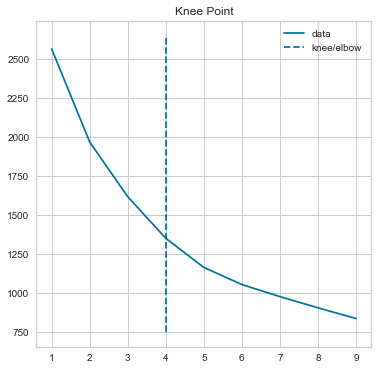

In [32]:
kneedle.plot_knee()

Both the silhouette score and the KneeLocator suggest k = 4 to be the best value.

In [33]:
# storing best k value according to KneeLocator in variable k_best
k_best = kneedle.knee

# storing model with best results in variable model_best
model_best = models[k_best]

/Users/rfunke/.virtualenvs/myvirtualenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



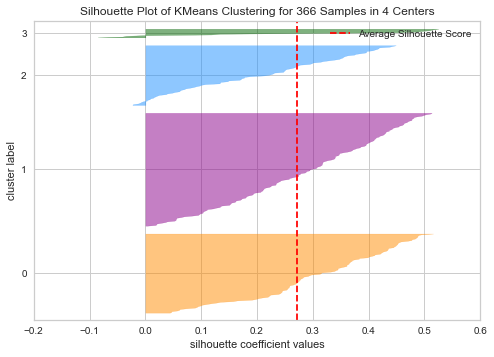

In [34]:
# plotting KMeans silhouette plot for k=4
silhouette_visualizer(model_best, dfs, 
                    colors=[
                    'darkorange', 
                    'darkmagenta', 
                    'dodgerblue', 
                    'darkgreen',]);

How to read this chart:
- x axis: tells how close a point is to the other points in the same cluster
- values below zero: these are points which are closer on average to points in another cluster than to points their own cluster
- y axis: how many points belong to a cluster


Oberservations:
- the average silhouette coefficient is close to 0.3 indicating a poor seperation of clusters
- cluster 3 (green) is the smallest cluster while it is also the most clearly defined and most compact cluster with a few points with values below zero 
- cluster 2 (blue) is the least compact cluster and has the least distance to the other clusters
- cluster 0 (orange) and cluster 1 (purple) are the largest clusters and have a similar shape, with no points with negative values

## Visualizing Cluster Centers

At this point we have chosen to use four clusters and computed our results on that. This gives us the clustering and the cluster centers for each variable. We can now plot these against each other to get visual representation. To do this we will use a line plot.

In [35]:
# storing cluster centers
cluster_centers = pd.DataFrame(model_best.cluster_centers_, columns=dfs.columns)

# ranaming index to 'cluster'
cluster_centers.index.name = 'cluster'

In [36]:
# plotting cluster centers on line plot
px.line(cluster_centers.T, labels = {
        'index': 'Features',
        'value': 'standardized value',
        'cluster': 'Cluster'},
        title='KMeans Clustering')

Upon inspecting the plot we find some lines which have significant peaks on certain variables. By looking at the highest value across all variables for specific line we can deduct certain patterns we can relate to.

- Cluster 0 (blue line) is characterized by unusually low air temperature compared to the other clusters. Furthermore we can oberserve that this coincides with high humidity and little sunshine. We can therefore conclude, this describes a typical autumn or winter day.
- Cluster 1 (red line) is characterized by unusually high solar radiation, coinciding with high air temperature and low relative humidity. So we conclude this to be a sunny summer day.
- Cluster 2 (green line) is characterized by unusually high wind velocity coincidig with low air pressure and cloudy skies. We conclude this to be cloudy and windy day.
- Cluster 3 is characterized by unusually high rain fall. This coincides with low air pressure, temperatures are similar to a typical sunny day, high humidity and cloudy skies. These are hot days with summmer thunderstorms.

In [37]:
px.scatter(df, x='air temperature (°C)', y='solar radiation (W/m²)')

In [38]:
px.scatter(df, x='air temperature (°C)', y='solar radiation (W/m²)')

## Visualizing Value Distribution per Cluster

The problem with the plot line above is that we can not tell what the value distribution of the features looks like. A value around zero could mean all points are actually close to the average, it could also mean only a few points are close to the average while the rest are spread far in a different direction. 

To get clarify this, we visualize the value distribution using split violin plots. 

In [39]:
# storing descaled cluster centers
km_descaled_cluster_centers = pd.DataFrame(scaler.inverse_transform(cluster_centers), columns=cluster_centers.columns)

# renaming index to 'cluster'
km_descaled_cluster_centers.index.name = 'cluster'

In [40]:
# storing a copy of the scaled datafram
df_viz_a = dfs.copy()

# adding column with cluster assignments
df_viz_a['cluster'] = model_best.predict(dfs)

In [41]:
# writing function to display violin plots
def plot_violin(model, df, cluster):
    """Plots a violin plot feature distribution of a given cluster

    Args:
        dataframe: a dataframe
        cluster (int): Describes the cluster

    Returns:
        _type_: Violin plot for a chosen cluster
    """
    fig = go.Figure()
    showlegend = True
    for column in df.columns:
        if column == 'cluster':
            continue
        fig.add_trace(go.Violin(y=df[column][df['cluster'] == cluster],
                                x=[column]*len(df),
                                scalegroup=column, name='in cluster',
                                side='negative',
                                line_color='blue',
                                points=False,
                                showlegend=showlegend
                                )
                    )
        fig.add_trace(go.Violin(y=df[column][df['cluster'] != cluster],
                                x=[column]*len(df),
                                scalegroup=column, name='not in cluster',
                                side='positive',
                                line_color='red',
                                points=False,
                                showlegend=showlegend
                                )
                    )
        showlegend = False
    fig.update_traces(meanline_visible=True)
    fig.update_layout(
        violinmode='overlay',
        title=f"{model}: Value distributions for cluster {cluster}",
        xaxis_title="Features",
        yaxis_title="standardized value",
        # legend_title="Legend Title",
    )
    return fig

In [42]:
plot_violin('KMeans', df_viz_a, 0)

Cluster 0 (blue line) - autumn / wintery days:

This weather pattern is characterized by unusually low air temperature compared to the other clusters. Furthermore we can oberserve that coincides with low air pressure, high humidity and little sunshine. We can therefore conclude this describes a typical winter day.

- air pressure: is slightly higher on these days than on other days
- air temperature: the average and minimum air temperature is lower on these days than on other days
- relative humidity: the average and the maximum value is much higher on autumn days than on other days
- wind velocity: lower on average on these days than on other days
- rain: it rains less on winter days than on other days
- solar radiation: the average and the minimum sunshine on winter days is below other days

In [43]:
plot_violin('KMeans', df_viz_a, 1)

Cluster 1 (red line) - sunny summer days:

This weather pattern is characterized by unusually high solar radiation (sunny weather) coinciding with high air temperature and low relative humidity. So we conclude this to be typical summer day. The average and the maximum solar radiation in this cluster is higher than in the other clusters.

- air pressure: is slightly higher on average on sunny days
- air temperature: is above average and maximum air temperatures on sunny days compared to other days
- relative humidity: is lower on average on sunny days
- wind velocity: there is less wind on average on sunny days
- rain: on average it rains less on sunny days than on other days
- solar radiation: the average and maximum values are higher compared to other days

In [44]:
plot_violin('KMeans', df_viz_a, 2)

Cluster 2 (green) / windy days:

This weather pattern is characterized by unusually high wind velocity coincidig with low air pressure and cloudy skies. The average and the maximum wind speed are significantly higher in this cluster compared to the other clusters.

- air pressure: average and minimum air pressure is lower than on other days
- air temperature: is slightly below average
- relative humidity: slightly below average
- wind velocity: is higher on average with much higher maximum values compared to other days
- rain: on average it is as rainy on windy days as on other days
- solar radiation: there is less sunshine on average on windy days

In this cluster we find a curiosity regarding wind direction. From looking at the table with descaled cluster centers. We find the average value for wind direction to be 206. In nautical terms this is South by Southwest: for germany this usually means strong winds coming in from southern europe and the atlantic.

In [45]:
plot_violin('KMeans', df_viz_a, 3)

Cluster 3 (purple) / summer thunderstorms:

This weather pattern is characterized by unusually high rain fall. This coincides with low air pressure, temperatures around typical summer day, high humidity and cloudy skies. These are days with summmer thunderstorms. The average and the max value for rain fall are significantly higher in this cluster compared to the other clusters.

- air pressure: is lower on average on summer days compared to other days
- air temperature: is slightly above on average with a very similar range compared to other days 
- relative humidity: is higher on average on these days
- wind velocity: is around average on these days compared to other days
- rain: the average and the maximum amount of rainfall on these days is much higher than on other days
- solar radiation: is lower on average on these days compared to other days

In [46]:
# printing descaled cluster centers
km_descaled_cluster_centers

,air pressure,air temperature,relative humidity,wind velocity,wind direction,rain,solar radiation
cluster,,,,,,,
0,1003.095020,5.961587,87.960213,1.368278,156.219809,0.006452,48.436576
1,1002.099637,14.753633,69.800143,1.557863,145.464218,0.003213,223.673124
2,992.486673,9.255382,72.181635,2.923093,206.475829,0.009815,74.914996
3,992.447404,13.906677,89.921031,1.639714,173.607943,0.155844,74.263307


## Conclusion KMeans

Computing four clusters using the KMeans algorithm yielded well interpretable clusters. Each cluster describes a weather condition we are used to in germany.

We found patterns with autumn/wintery days, with sunny summer days, with windy days and with summer thunderstorms.

# Clustering with GMM

We will try to use gaussian mixture models to cluster the same data set. Since the data appears to be not well inseparable (see scatter plots above), gaussian mixture models might be able to produce a good clustering.

Similar as in the KMeans approach, we need to determine the best number of components (number of clusters). To do this we are going to compute the algorithm with multiple numbers of gaussian components, before continuing our analysis with the optimal number of components.

To evaluate the performance of the different options we are going to use the BIC and AIC values instead of silhouette score as in the KMeans clustering. In our case BIC and AIC are better suited to interpret results of gaussian mixture models than the silhouette score.

In [47]:
# importing gaussian mixture models
from sklearn.mixture import GaussianMixture

In [48]:
# writing a function to compute the algorithm with different numbers of components
def calculate_gm_models(X, n_components):
    models = {}
    for n in range(*n_components):
        model = GaussianMixture(n_components=n, covariance_type='full', random_state=1)
        model.fit(X)
        models[n] = model
    return models

In [49]:
# importing plotting library
import matplotlib.pyplot as plt

# number of components is 1 thorugh to 20
n_components = np.arange(1, 21)

# running the using same data and the range of number of components
# storing the results in variable 'models'
models = [GaussianMixture(n, covariance_type='full', random_state=1).fit(dfs)
          for n in n_components]

df_aic_bic = pd.DataFrame({
    'number of gaussian components': n_components,
    'AIC': [m.aic(dfs) for m in models],
    'BIC': [m.bic(dfs) for m in models]})

df_aic_bic = df_aic_bic.set_index('number of gaussian components')

In [50]:
px.line(df_aic_bic, labels = {
        'value': 'score',
        'variable': 'Meassure'},
        title='AIC and BIC against number of gaussian components')

How to read this chart:
- lower is better

Oberservations:
- lowest BIC value is for 5 components
- lowest AIC value is for 15 components

Procedure:
- because clustering days into 15 clusters doensn't seem sensible we are going to use 5 components instead
- this also matches the number of clusters used in the KMeans appoach earlier

In [51]:
px.scatter(df, x='air temperature (°C)', y='solar radiation (W/m²)')

In [52]:
px.scatter(df, x='air temperature (°C)', y='solar radiation (W/m²)')

For confirmation of our choice for the number of components we are also going to compute the silhouette score for different number of components. If we get overlapping results of the BIC and silhouette score, we can be even more confident in our choice.

In [53]:
# writing function to compute silhouette coefficient values for gaussian mixture models
def gm_sil_coef_plot(X, models):
    silhouette_coefficients = {
        n: sklearn.metrics.silhouette_score(X, model.predict(X))
        for n, model in models.items()}

    fig = px.line(
        x=silhouette_coefficients.keys(),
        y=silhouette_coefficients.values(),
        title='Silhouette Coefficient vs number of components',
        height=640,
        width=720,
        labels={
            'x': 'Number of gaussian components',
            'y': 'silhouette coefficient'})

    return fig

In [54]:
# calling funciton to calculate gaussian mixture models with different number of components
# storing results in variable 'models'
models = calculate_gm_models(dfs, (2, 10))

In [55]:
# calling function to compute and plot silhouette coefficient values
gm_sil_coef_plot(dfs, models)

The resulting silhouette coefficient values are even lower than the result in the KMeans. The reason for this is as mentioned earlier: poor seperation between clusters.

Both the BIC and silhouette coefficient suggest 5 to be best choice for number of components. So we will proceed with this choice.

In [56]:
# storing model and configuration in variable 'gm'
gm=GaussianMixture(n_components=5, random_state=1) # 5 is best value based on BIC and silhouette coefficient

# computing the model and storing results in variable 'cluster_assignments' 
cluster_assignments = gm.fit_predict(dfs)

In [57]:
# storing cluster centers (means) in variable 'gmm_means'
gmm_means = pd.DataFrame(gm.means_, columns=dfs.columns)

# ranaming index to 'cluster'
gmm_means.index.name = 'cluster'

In [58]:
# plotting cluster centers on line plot
px.line(gmm_means.T, labels = {
        'index': 'Features',
        'value': 'standardized value',
        'cluster': 'Cluster'},
        title='Gaussian Mixture Models Clustering')

In principal with gaussian mixtures models we find the same pattern as with KMeans. There windy days, rainy days, cold days and hot days. Though the cluster are concentrated around a single variable with an extrene value, while the value of the other variables in the same cluster are often around average.

While being complementary to the KMeans approach, the gaussian mixture models produces a less pronunced clustering.

In [59]:
# storing descaled cluster centers
descaled_cluster_centers = pd.DataFrame(scaler.inverse_transform(gm.means_), columns=cluster_centers.columns)

# renaming index to 'cluster'
descaled_cluster_centers.index.name = 'cluster'

The clustering resulting from the gaussian mixture models isn't much different or better than the KMeans clustering, so we are not going to elaborate in detail on the feature distribution of this clustering. However we include the distribution plots for documentation purposes.

In [60]:
# storing a copy of the scaled datafram
df_viz_b = dfs.copy()

# adding column with cluster assignments
df_viz_b['cluster'] = gm.predict(dfs)

In [61]:
plot_violin('GMM', df_viz_b, 0)

In [62]:
plot_violin('GMM', df_viz_b, 1)

In [63]:
plot_violin('GMM', df_viz_b, 2)

In [64]:
plot_violin('GMM', df_viz_b, 3)

In [65]:
plot_violin('GMM', df_viz_b, 4)

In [66]:
# printing descaled cluster centers
descaled_cluster_centers

,air pressure,air temperature,relative humidity,wind velocity,wind direction,rain,solar radiation
cluster,,,,,,,
0,1004.292708,3.777525,87.120254,1.380406,154.240791,0.000004,42.768941
1,996.982377,14.630087,79.525724,1.530525,165.216777,0.016054,147.782887
2,996.035247,7.241234,77.703950,2.596302,206.902712,0.010754,53.438092
3,995.011124,13.072377,89.649909,1.829224,159.446792,0.114586,61.637902
4,1001.477793,13.001591,68.490459,1.835758,150.808500,0.000025,199.839508


### Conclusion Gaussian Mixture Models

The gaussian mixture models produced a similar result compared to clustering of KMeans. Though the patterns are less pronunced and less relatable. Therefore we prefer the KMeans clustering over the gaussian mixture models clustering.

# Hierarchical Agglomerative Clustering

To solidify or expand our findings we are going to use a hierarchical agglomerative clustering approach. In this procedure we will run the model several times with sole difference being the number of clusters (3, 4 and 5).

In [67]:
agg_3 = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete', compute_distances=True)
agg_4 = cluster.AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete', compute_distances=True)
agg_5 = cluster.AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete', compute_distances=True)
labels_3 = agg_3.fit_predict(dfs)
labels_4 = agg_4.fit_predict(dfs)
labels_5 = agg_5.fit_predict(dfs)

In [68]:
dfs_3n = dfs.copy()
dfs_4n = dfs.copy()
dfs_5n = dfs.copy()

In [69]:
dfs_3n['cluster']=labels_3
dfs_4n['cluster']=labels_4
dfs_5n['cluster']=labels_5

In [70]:
cluster_means_3n = dfs_3n.groupby('cluster').mean()

# plotting cluster centers on line plot
px.line(cluster_means_3n.T, labels = {
        'index': 'Features',
        'value': 'standardized value',
        'cluster': 'Cluster'},
        title='HAC: 3 Components Clustering')

In [71]:
cluster_means_4n = dfs_4n.groupby('cluster').mean()

# plotting cluster centers on line plot
px.line(cluster_means_4n.T, labels = {
        'index': 'Features',
        'value': 'standardized value',
        'cluster': 'Cluster'},
        title='HAC: 4 Components Clustering')

In [72]:
cluster_means_5n = dfs_5n.groupby('cluster').mean()

# plotting cluster centers on line plot
px.line(cluster_means_5n.T, labels = {
        'index': 'Features',
        'value': 'standardized value',
        'cluster': 'Cluster'},
        title='HAC: 5 Components Clustering')

### HAC Conclusion

We find a similar clustering as previously. (There continues to be a rainy, windy, cold, sunny clusters.) Both the clusterings produced by Kmeans and GMM are superior for practical purposes, with the clustering produced by KMeans being the most relavant for our application.

For this reason we will not elaborate on the feature distribution for each cluster in detail. However we include the distribution plots for documentation purposes.

### HAC Appendix

In [73]:
# storing a copy of the scaled datafram
df_viz_c = dfs.copy()

# adding column with cluster assignments
df_viz_c['cluster'] = labels_5

In [74]:
plot_violin('HAC', df_viz_c, 0)

In [75]:
plot_violin('HAC', df_viz_c, 1)

In [76]:
plot_violin('HAC', df_viz_c, 2)

In [77]:
plot_violin('HAC', df_viz_c, 3)

In [78]:
plot_violin('HAC', df_viz_c, 4)

# Final Conclusion

With respect to the task given to us by the Tourist Information Halle, we were able to identify four characteristic weather patterns: 

Autumn and winter days: on these the temperature can drop as low as -7°C with an average around 6°C, while there is always a chance for rain these days can also be entirely rain free. To dress accordingly one should wear a warm baselayer and waterproof shell, also gloves are recommended.

Sunny summer days: these days are characterized by warm temperatures of up to 36°C and high humidty with an average around 70%. Our suggestion is to dress inlight clothes which are bareable in warm weather. 

Windy days: are characterized by high average windspeeds and moderate temperatures. Sometimes this conicides with some rainfall making these really uncomfortable days. We recommend to wear a light to moderate wind and waterproof jacket.

Summer thunderstorms: while being warm and humid during the days the afternoons are often marked by massive thunderstorms with enormous amounts rainfall in a very short time. We recommend regular summer clothes and if it is unavoidable to be outside during rainfall carry an umbrella, though it is preferable to be under shelter before it starts to rain, because on days like this, when it rains it pours.

## Typical day during each characteristic weather pattern
Below we have listed minimum, average and maximum values for each variable for all clusters.

- Cluster 0 - autumn winter days
- Cluster 1 - summer sunny days
- Cluster 2 - windy days
- Cluster 3 - summer thunderstorms

In [79]:
# TODO explain what this is and why we do it
cluster_assignments = model_best.predict(dfs)

df_min['cluster'] = cluster_assignments
df_min.groupby('cluster').min()

,air pressure (mbar),air temperature (°C),relative humidity (%),wind velocity (m/s),wind direction (°),rain (mm),solar radiation (W/m²)
cluster,,,,,,,
0,975.69,-7.14,43.85,0.14,0.0,0.0,0.0
1,977.45,-8.13,16.85,0.00,0.0,0.0,0.0
2,965.17,-2.77,24.69,0.22,0.0,0.0,0.0
3,979.70,0.23,40.89,0.00,0.0,0.0,0.0


In [80]:
df['cluster'] = cluster_assignments
df.groupby('cluster').mean()

,air pressure (mbar),air temperature (°C),relative humidity (%),wind velocity (m/s),wind direction (°),rain (mm),solar radiation (W/m²)
cluster,,,,,,,
0,1003.095020,5.961587,87.960213,1.368278,156.219809,0.006452,48.436576
1,1002.099637,14.753633,69.800143,1.557863,145.464218,0.003213,223.673124
2,992.486673,9.255382,72.181635,2.923093,206.475829,0.009815,74.914996
3,992.447404,13.906677,89.921031,1.639714,173.607943,0.155844,74.263307


In [81]:
df_max['cluster'] = cluster_assignments
df_max.groupby('cluster').max()

,air pressure (mbar),air temperature (°C),relative humidity (%),wind velocity (m/s),wind direction (°),rain (mm),solar radiation (W/m²)
cluster,,,,,,,
0,1030.63,26.10,100.0,37.22,360.0,2.585,786.45
1,1022.25,36.55,100.0,28.71,359.9,4.160,1081.60
2,1012.60,27.22,100.0,30.34,359.7,2.200,1028.63
3,1001.77,30.84,100.0,34.16,360.0,10.360,952.79
